# Identification
Please indicate your name and parcours (e.g.: IMA, DIGIT, BIM, DAC, ..., Erasmus)

Student 1: Andrei Aralov (DIGIT)

Student 2: Andrea Cosentino (IQ)

# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercise 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [19]:
def conv2d(a, b):
    return convolve2d(a, b, mode='same')

def SobelDirs(I):
    sx = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ])
    gx = conv2d(I, sx)
    
    sy = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    gy = conv2d(I, sy)
    
    return gx, gy

def SobelDetector(I, s):
    """ Array*double -> Array """
    gx, gy = SobelDirs(I)
    r = np.sqrt(gx**2 + gy**2)
    return r > s

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [20]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    l = np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ])
    d = conv2d(I, l)
    res = np.zeros_like(I)
    for i in range(1, I.shape[0] - 1):
        for j in range(1, I.shape[1] - 1):
            neigh = d[i - 1 : i + 2, j - 1 : j + 2]
            assert(neigh.shape == (3, 3))
            mx = np.max(neigh)
            mn = np.min(neigh)
            if mx > 0 and mn < 0 and mx - mn > s:
                res[i, j] = 1
    return res

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

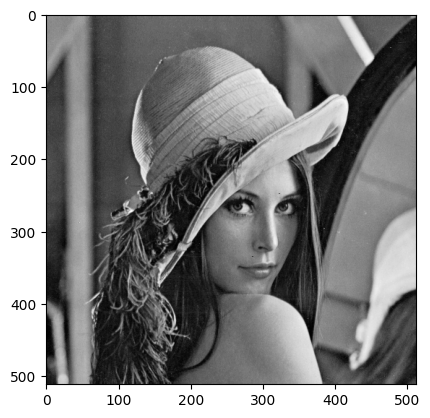

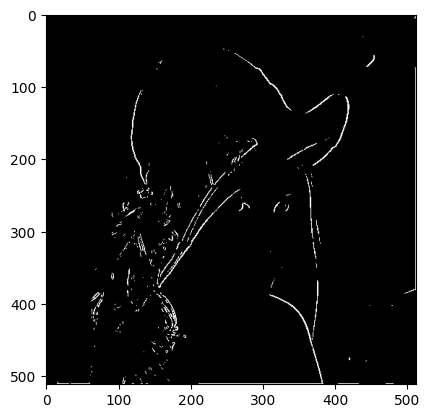

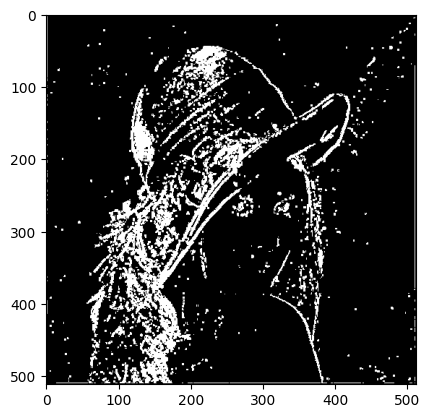

In [21]:
lena = np.asarray(Image.open('img/lena.png'))

plt.imshow(lena, cmap='gray')
plt.show()


sobel = SobelDetector(lena, 350)
plt.imshow(sobel, cmap='gray')
plt.show()

laplacian = LaplacianDetector(lena, 100)
plt.imshow(laplacian, cmap='gray')
plt.show()

## Exercise 2: non maximum suppression

This exercise addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the notebook to see pixels value pointed by the mouse screen. **Warning**, this mode works only with jupyter notebook up to version 6).

In [90]:
%matplotlib notebook
# !pip3 install notebook=6 (if necessary)

#### your answer below

img = np.asarray(Image.open('img/tools.png'))

gx, gy = SobelDirs(img)
O = orientation(gx, gy, np.sqrt(gx**2 + gy**2))

imshow_hot(O, 'tools')

<IPython.core.display.Javascript object>

Explain the different values given to a pixel by `orientation()`:

**Answer**: the values describe the orientation of the edges. For example, if the orientation is 0 then the value is 1 and, in the image, has color red. Orange is associated to value 2 (orientation 45°), yellow to 3 (orientation 90°) and finally white to value 4 (orientation 135°).

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [34]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    assert Ig.shape == Ior.shape
    r = np.zeros_like(Ior)
    for i in range(1, Ig.shape[0] - 1):
        for j in range(1, Ig.shape[1] - 1):
            d = Ior[i, j]
            neigh = Ig[i - 1 : i + 2, j - 1 : j + 2]
            ok = False
            if d == 1:
                ok = neigh[1, 1] > neigh[1, 0] \
                    and neigh[1, 1] > neigh[1, 2]
            if d == 2:
                ok = neigh[1, 1] > neigh[2, 0] \
                    and neigh[1, 1] > neigh[0, 2]
            elif d == 3:
                ok = neigh[1, 1] > neigh[0, 1] \
                    and neigh[1, 1] > neigh[2, 1]
            elif d == 4:
                ok = neigh[1, 1] > neigh[0, 0] \
                    and neigh[1, 1] > neigh[2, 2]
            if ok and Ig[i, j] > 0:
                r[i, j] = Ig[i, j]
    return r

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


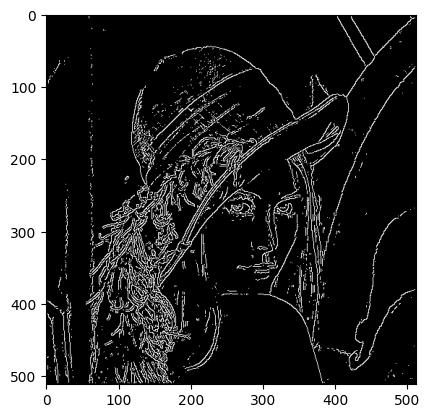

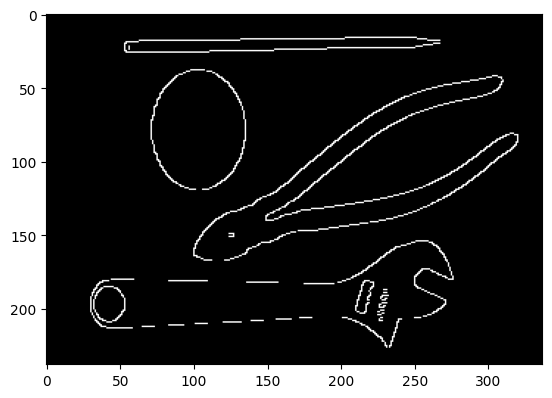

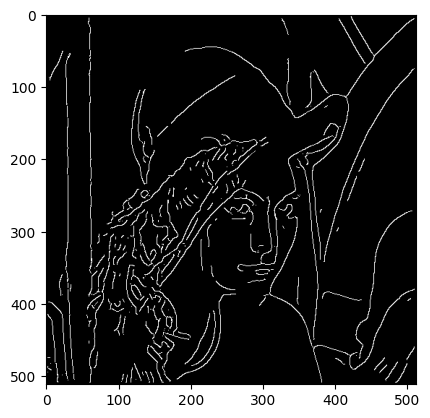

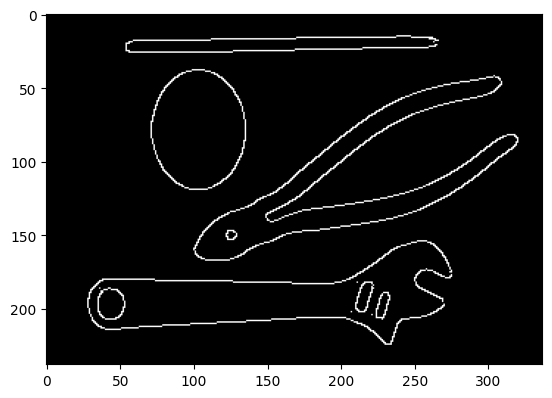

In [94]:
%matplotlib inline
### your answer below

def proc_img(img, s):
    # plt.imshow(img, cmap='gray')
    # plt.show()
    
    gx, gy = SobelDirs(img)
    gn = np.sqrt(gx**2 + gy**2)
    O = orientation(gx, gy, gn)

    # plt.imshow(gn, cmap='gray')
    # plt.show()
    
    e_nms = nms(gn, O)
    plt.imshow(e_nms > s, cmap='gray')
    plt.show()

proc_img(lena, 100)
proc_img(img, 50)

proc_img(conv2d(lena, gaussianKernel(3)), 30)
proc_img(conv2d(img, gaussianKernel(3)), 20)


4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

**Answer**: the thickness of edges doesn't change because of the filtering, since we use non-max suppression.
However, the filtering reduces the noise and makes transitions smoother. This is visible:
1. In the first image, much less "not-significant" edges especially in the region corresponding to hair and feathers (which could be considered a high-frequency texture)
2. In the second image, the edges after filtering form closed contours

## Exercise 3:  effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

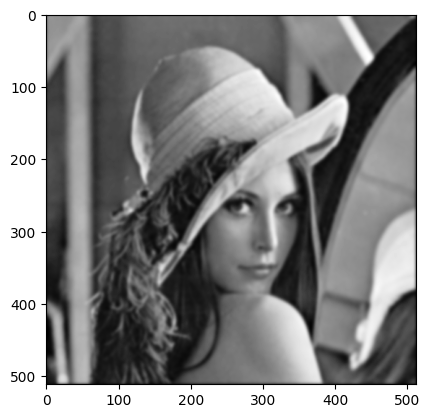

In [25]:
lena_smooth = conv2d(lena, gaussianKernel(2))

plt.imshow(lena_smooth, cmap='gray')
plt.show()

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

**Answer**: laplacian filter seems to be less robust to noise, which is present even after filtering

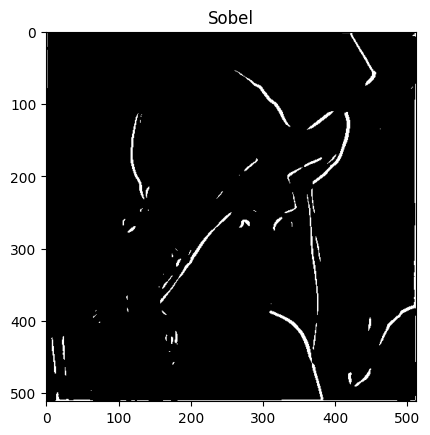

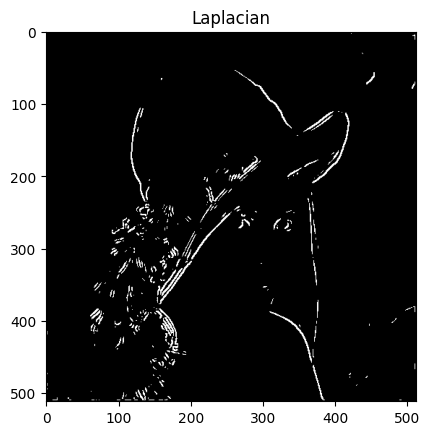

In [42]:
lena_sobel = SobelDetector(lena_smooth, 150)
lena_laplacian = LaplacianDetector(lena_smooth, 10)

plt.title('Sobel')
plt.imshow(lena_sobel, cmap='gray')
plt.show()

plt.title('Laplacian')
plt.imshow(lena_laplacian, cmap='gray')
plt.show()

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

**Answer**: Smoothing makes noise less relevant but also makes edges (transitions) less defined

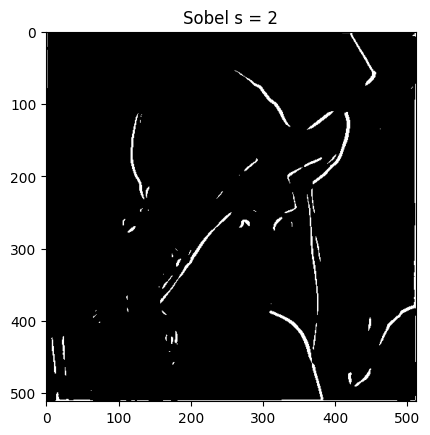

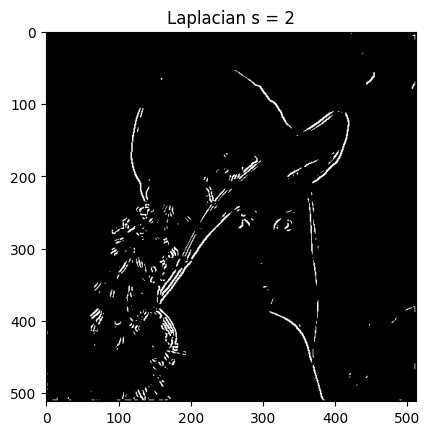

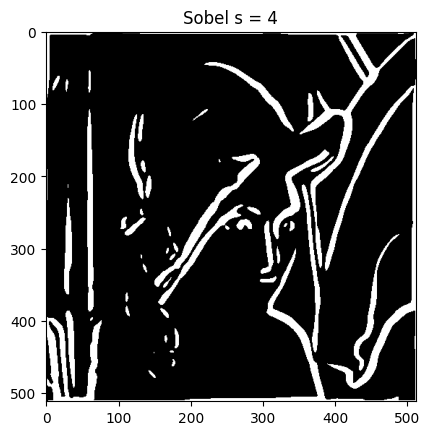

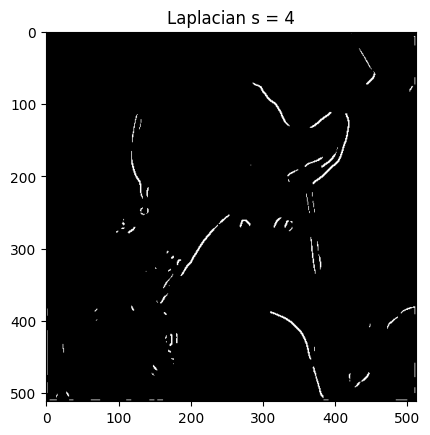

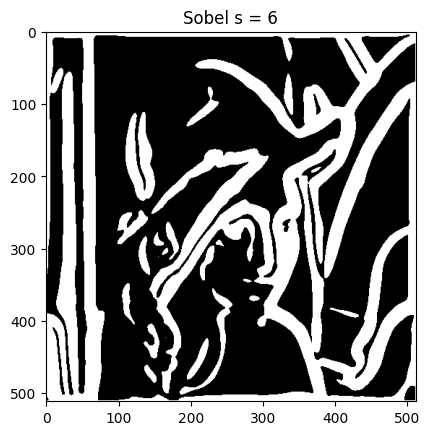

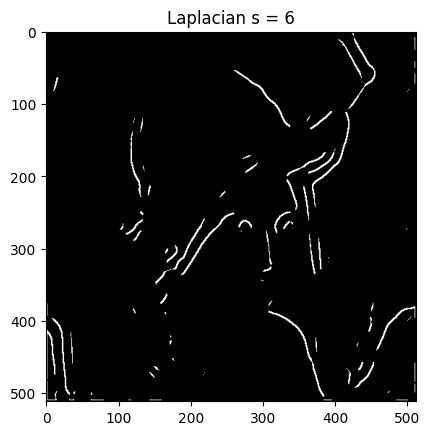

In [51]:
ss = [2, 4, 6]
ts = [(150, 10), (50, 2), (20, 0.5)]

for s, t in zip(ss, ts):
    lena_smooth = conv2d(lena, gaussianKernel(s))
    lena_sobel = SobelDetector(lena_smooth, t[0])
    lena_laplacian = LaplacianDetector(lena_smooth, t[1])
    
    plt.title(f'Sobel s = {s}')
    plt.imshow(lena_sobel, cmap='gray')
    plt.show()
    
    plt.title(f'Laplacian s = {s}')
    plt.imshow(lena_laplacian, cmap='gray')
    plt.show()

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.


**Answer**: this filter amplifies noise and therefore edge detection performs worse. Also, since Laplacian is second-order method, its result becomes even worse than for Sobel.

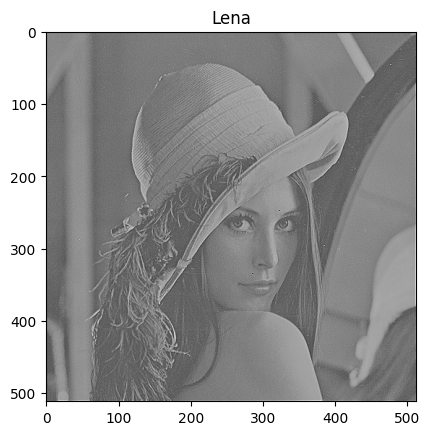

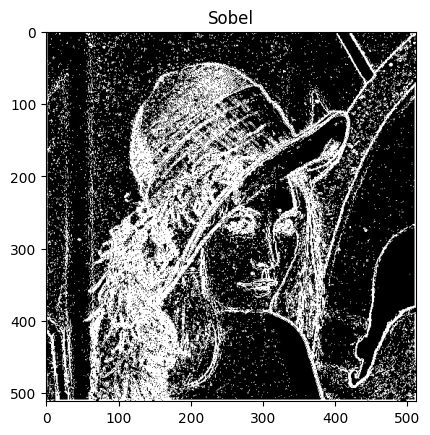

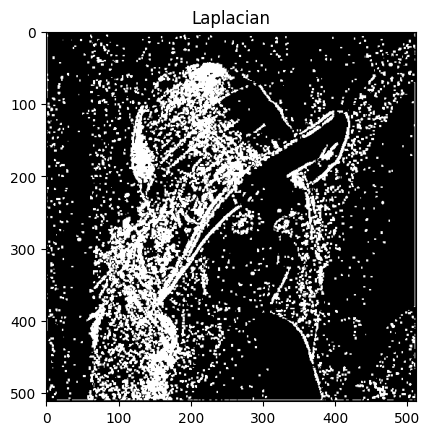

In [60]:
f = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

lena_ench = conv2d(lena, f)
lena_sobel = SobelDetector(lena_ench, 120)
lena_laplacian = LaplacianDetector(lena_ench, 450)

plt.title('Lena')
plt.imshow(lena_ench, cmap='gray')
plt.show()

plt.title('Sobel')
plt.imshow(lena_sobel, cmap='gray')
plt.show()

plt.title('Laplacian')
plt.imshow(lena_laplacian, cmap='gray')
plt.show()

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

**Answer**: 
1. First few iterations produce meaningful results, although the quality of localization of contours is decresing
2. After some level, results become not really useful (when the size reaches 32 by 32 pixels)
3. Edges localisation by Laplacian filter becomes worse faster than the edges localisation by Sobel filter.

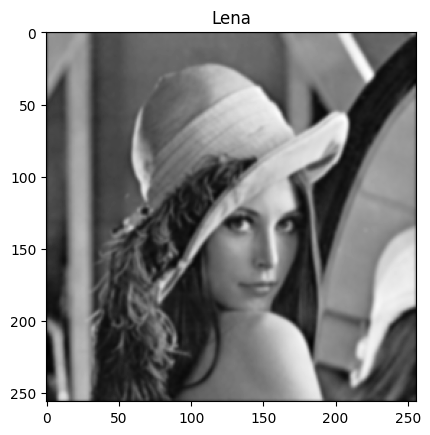

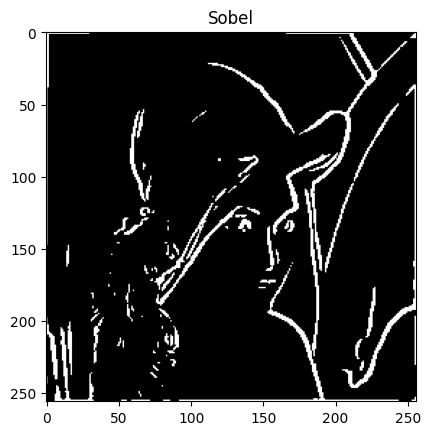

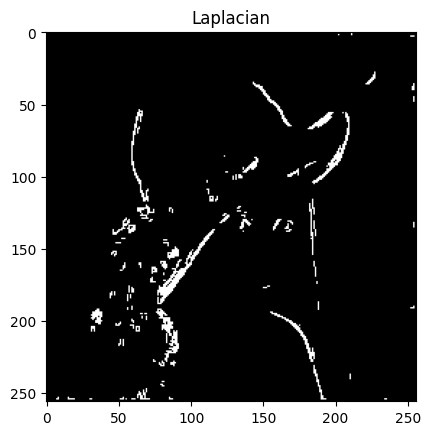

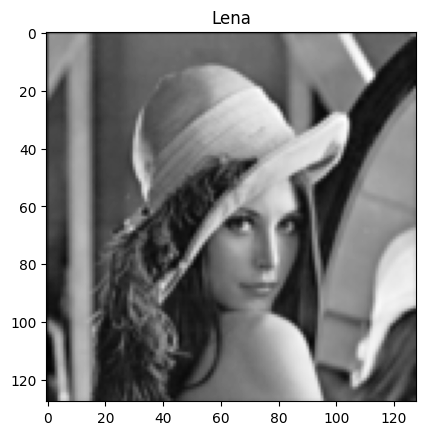

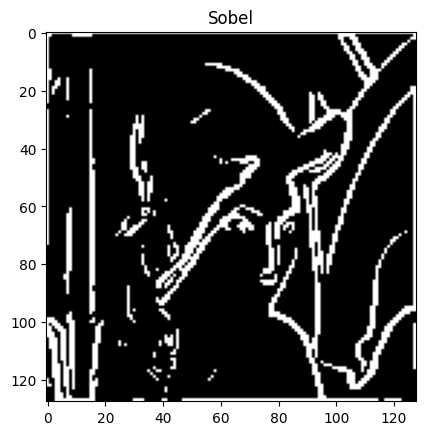

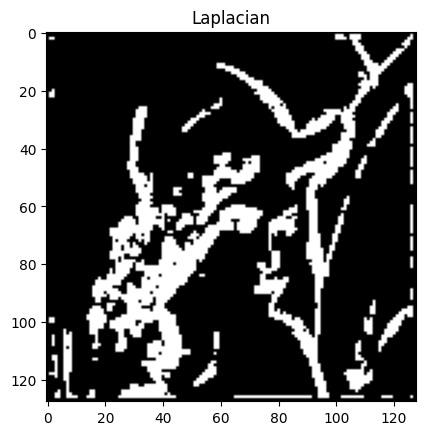

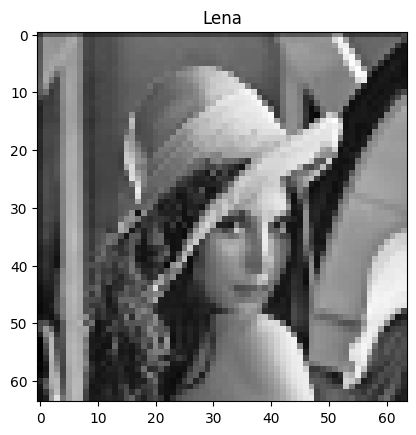

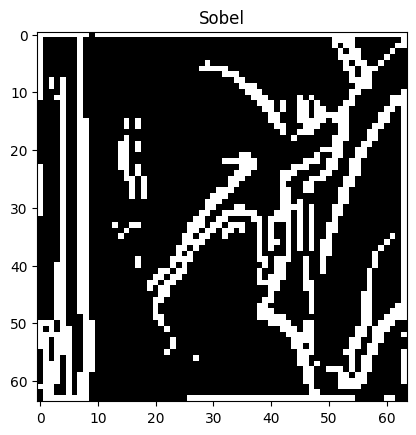

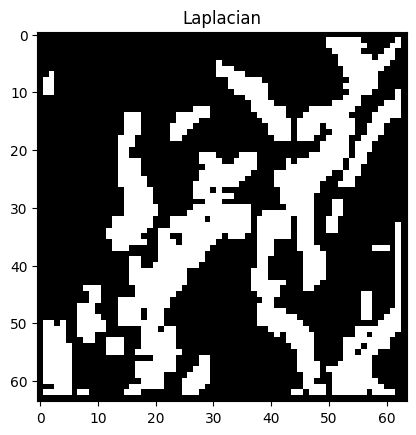

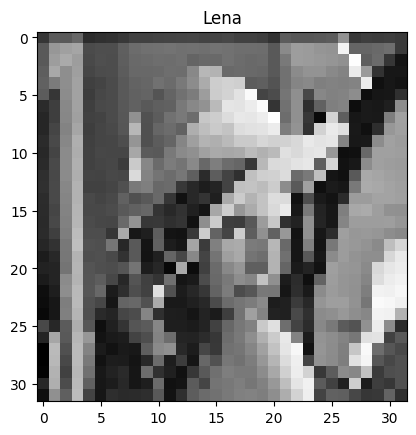

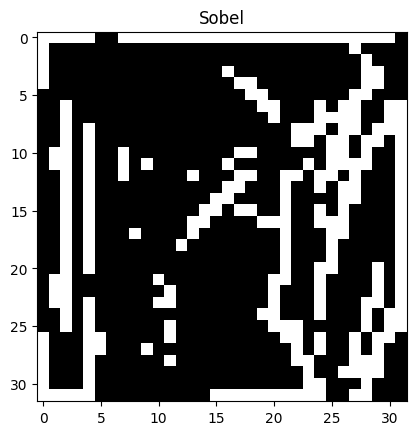

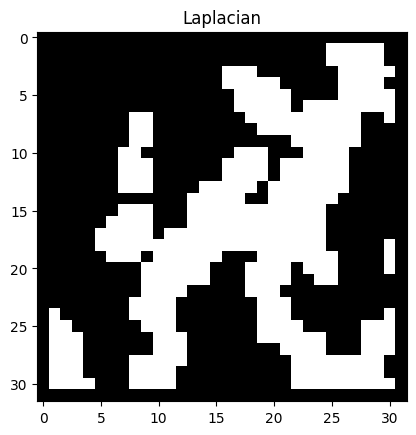

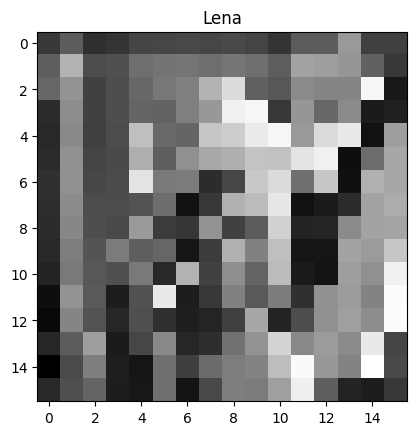

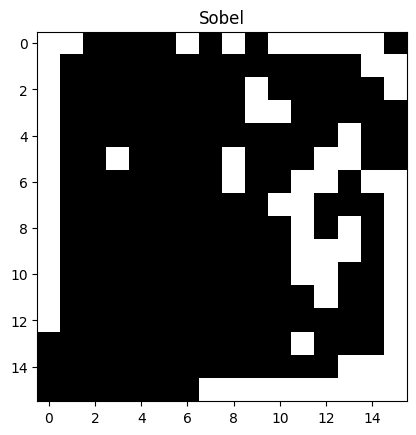

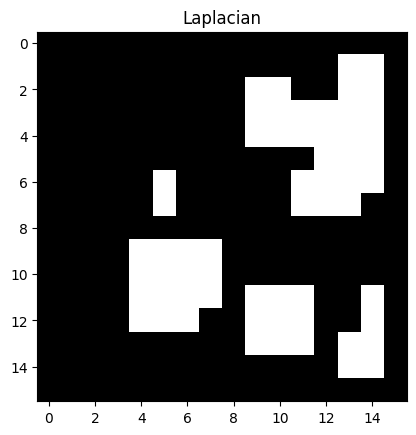

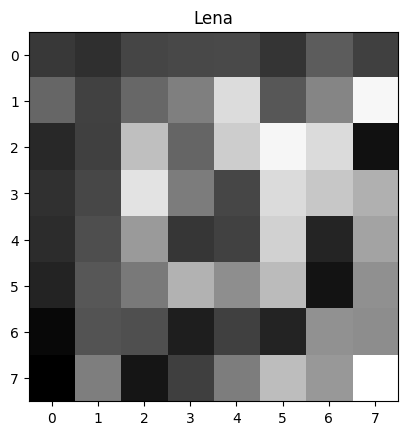

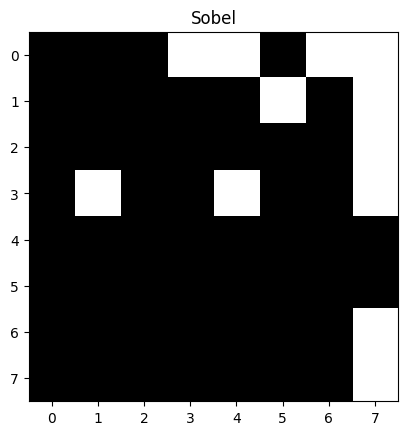

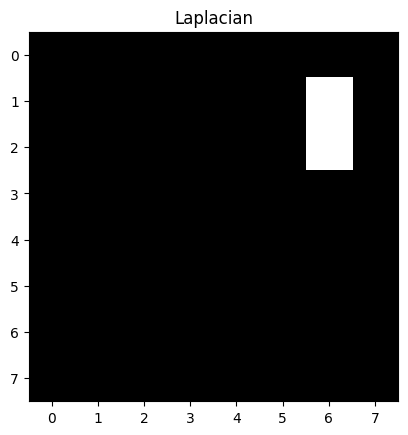

In [89]:
def subsample(image,factor):
    return image[::factor,::factor]



def subsampleSmooth(img, k):
    img = conv2d(img, gaussianKernel(2))
    return subsample(img, k)


ts0 = 150
ts1 = 30
i = 0

lena_sub = lena.copy()
while lena_sub.shape[0] > 8:
    i += 1
    lena_sub = subsampleSmooth(lena, 2 ** i)
    
    lena_sobel = SobelDetector(lena_sub, ts0 * (1.2 ** i))
    lena_laplacian = LaplacianDetector(lena_sub, ts1 * (1.8 ** i))
        
    plt.title('Lena')
    plt.imshow(lena_sub, cmap='gray')
    plt.show()
    
    plt.title('Sobel')
    plt.imshow(lena_sobel, cmap='gray')
    plt.show()
    
    plt.title('Laplacian')
    plt.imshow(lena_laplacian, cmap='gray')
    plt.show()